Source 
http://mc-stan.org/users/documentation/case-studies/radon.html?fbclid=IwAR3h_03XtQnyJQ18EOdREkPX-4biDX7c5AN5e9DPQzQLZ6hB2JRFh1gHemQ
http://mc-stan.org/users/documentation/case-studies/tutorial_rstanarm.html

# PROJECT WORK
#### 1. Problem Description 

The dataset is a 4000 rows dataset collecting from math and reading results of students from 79 different schools. The variables are class size, teaching experience, free lunch, race.
The dataset is obtained from http://vincentarelbundock.github.io/Rdatasets/datasets.html

For the scope of this project work, we focus on the effect of teaching experience on math scores. The calculation is done on log-scale. 


Data distribution:
![Math](./Fig/Math.png)

#### 2. Model description

 
We examine 3 models: 
- Pooled model: all school is the same, regress y(math scores) solely based on x(teaching experience)
- Separate model: each school has its own model
- Hierarchical model: 

Split up training-test data with the corresponding percentage 75-25 to evaluate model performance. 

#### 2.1. Pooled model 

Looking at the math score distribution, the model is roughly normally distributed. Therefore we choose Normal distribution for modeling. 
Stan code:

`data {
    int<lower=0>  N; //Number of train data
    int<lower=0> M; //Number of test data
    vector[N] x; // Variable - teaching experience
    vector[M] x_test; // Test variable 
    vector[N] y; // Labels - log math score
}
parameters {
    vector[2] beta;
    real<lower=0> sigma; //sigma is constrained to be positive 
}
model {
    y ~ normal(beta[1] + beta[2]*x, sigma); 
}
generated quantities{
    vector[N] log_lik;
    vector[M] y_pred_test;
    for (i in 1:M)
     y_pred_test[i] = normal_rng(beta[1] + beta[2]*x_test[i], sigma);
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| beta[1] + beta[2]*x[i], sigma);
}`

The code is passed to PyStan and simulated with 2 chains in 1000 iterations. 

#### 2.2. Separate model 
In the separate model, we add another variable named school indicator. 

Stan code

`data{
    int<lower=0> N;
    int<lower=1, upper=79> school[N]; #school indicator
    vector[N] x;
    vector[N] y;
}
parameters {
    vector[79] alpha;
    real beta; #only 1 beta, not a vector
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] y_hat;  
    for (i in 1:N)
        y_hat[i] <- beta* x[i] + alpha[school[i]];
}
model {
    y ~ normal(y_hat, sigma);
}
generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| y_hat[i], sigma);
}`

#### 2.3. Hierarchical model 
In this hierarchical model, the parameters for each schools are regarded as samples from the same population distribution.  
Stan code:

In [ ]:
#Stan code for hierarchical model 

#### 3. Convergence and Result
#### 3.1. Pooled model 

R-hat for all variables is approximately 1.0, so we can conclude that the model has converged.   
Result for alpha, beta


#### 3.2. Separate model  
R-hat for all variables is approximately 1.0, so we can conclude that the model has converged.  
Alpha calculated for different schools (ordered from low to high):
![Sepmodel_alpha](./Fig/Sep_model_alpha.png)


#### 3.3. Hierarchical model  



#### 3. Model comparison and posterior predictive checking 

Two methods for model evaluation has been used in this project: psis-loo and MAE.

Psis-loo results for each model:

| Measurements | Pooled model | Separate model | Hierarchical model |
| --- | --- | --- | --- |
| psis-loo | --- | --- | --- |
| p_eff | --- | --- | --- |
| k < 0.7 | --- | --- | --- |

Scatter plot of ks values for different models:

MAE result for each model:

#### 4. Prior choices and sensitivity analysis


In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
import stanity

In [4]:
star = pd.read_csv('Star.csv', index_col=0, header = 0)

In [5]:
star.head()

,tmathssk,treadssk,classk,totexpk,sex,freelunk,race,schidkn
2,473,447,small.class,7,girl,no,white,63
3,536,450,small.class,21,girl,no,black,20
5,463,439,regular.with.aide,0,boy,yes,black,19
11,559,448,regular,16,boy,no,white,69
12,489,447,small.class,5,boy,yes,white,79


In [6]:
len(np.unique(star.schidkn))

79

In [7]:
schools = star.schidkn.unique()

In [8]:
np.sort(schools)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80])

In [9]:
star.loc[star.schidkn>=78,'schidkn'] -= 1

In [10]:
schools = star.schidkn.unique()

In [11]:
df = pd.DataFrame()

In [12]:
for col in ['tmathssk', 'treadssk', 'totexpk', 'schidkn' ]:
    data = star.loc[:,col]
    df[col] = data
data = star.loc[:,['classk', 'sex', 'freelunk','race']]
df = df.merge(pd.get_dummies(data), left_index=True, right_index=True)

In [13]:
print(df.columns[[4, 6, 8]])
print(df.head())

Index(['classk_regular', 'classk_small.class', 'sex_girl'], dtype='object')
    tmathssk  treadssk  totexpk  schidkn  classk_regular  \
2        473       447        7       63               0   
3        536       450       21       20               0   
5        463       439        0       19               0   
11       559       448       16       69               1   
12       489       447        5       78               0   

    classk_regular.with.aide  classk_small.class  sex_boy  sex_girl  \
2                          0                   1        0         1   
3                          0                   1        0         1   
5                          1                   0        1         0   
11                         0                   0        1         0   
12                         0                   1        1         0   

    freelunk_no  freelunk_yes  race_black  race_other  race_white  
2             1             0           0           0           1  


In [14]:
df.drop(df.columns[[5, 7, 9, 12]], axis=1, inplace=True)

In [15]:
df.columns = ['math', 'reading', 'year_teaching', 'school','reg_class', 'sml_class', 'is_girl', 'free_lunch', 'black','white']

In [16]:
df.head()

,math,reading,year_teaching,school,reg_class,sml_class,is_girl,free_lunch,black,white
2,473,447,7,63,0,1,1,0,0,1
3,536,450,21,20,0,1,1,0,1,0
5,463,439,0,19,0,0,0,1,1,0
11,559,448,16,69,1,0,0,0,0,1
12,489,447,5,78,0,1,0,1,0,1


In [17]:
df.corr()['math'].sort_values()

free_lunch      -0.243111
black           -0.174493
reg_class       -0.036504
school           0.045439
sml_class        0.080078
is_girl          0.081041
year_teaching    0.096687
white            0.174968
reading          0.713549
math             1.000000
Name: math, dtype: float64

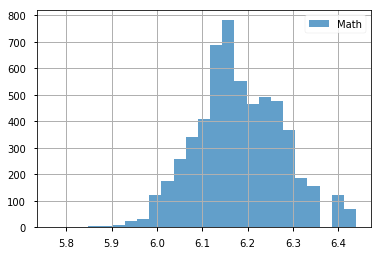

In [18]:
df.math.apply(lambda x:np.log(x)).hist(bins=25, alpha = 0.7, label = "Math") # Do we need to add +0.1?
plt.legend()
plt.show()


### Train/Test Split

In [19]:
X = df.drop('math', axis=1)
Y = np.log(df.math)

In [20]:
indices = range(df.shape[0])
i_schools = []
len_ischools = []

In [21]:
for s in schools:
    i_school = np.where(df.school == s)[0]
    len_ischools.append(len(i_school))
    i_schools.append(i_school)

In [22]:
min_len = min(len_ischools)
train_size = round(min_len*0.8)

In [23]:
train_idx = []
test_idx = []

In [24]:
for s in i_schools:
    np.random.shuffle(s)
    train_idx = np.concatenate((train_idx, s[:train_size]), axis=None)
    test_idx = np.concatenate((test_idx, s[train_size:]), axis=None)

In [25]:
len(train_idx)

2133

In [26]:
len(test_idx)

3615

In [27]:
X_train = X.iloc[train_idx,:]
X_test = X.iloc[test_idx,:]
Y_train = Y.iloc[train_idx]
Y_test = Y.iloc[test_idx]

## Pooled model 

In [27]:
pooled_code = """
data {
    int<lower=0>  N;
    int<lower=0> M;
    vector[N] x;
    vector[M] x_test;
    vector[N] y;
}
parameters {
    vector[2] beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(beta[1] + beta[2]*x, sigma);
}
generated quantities{
    vector[N] log_lik;
    vector[M] y_pred_test;
    for (i in 1:M)
     y_pred_test[i] = normal_rng(beta[1] + beta[2]*x_test[i], sigma);
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| beta[1] + beta[2]*x[i], sigma);
}

"""

In [38]:
import pystan

pool_data = {
    'N': Y_train.shape[0], 
    'M': Y_test.shape[0],
    'x': X_train.loc[:,'year_teaching'],
    'x_test': X_test.loc[:,'year_teaching'],
    'y': Y_train,
}

In [31]:
pooled_fit = pystan.stan(model_code=pooled_code, data = pool_data, iter = 1000, chains = 2)
print(pooled_fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_174aac4ec68a4e0adc2676445f7b9556 NOW.
/Users/haicuthe/anaconda2/envs/dev-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_174aac4ec68a4e0adc2676445f7b9556.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]             6.16  1.8e-4 3.8e-3   6.16   6.16   6.16   6.17   6.17    455    1.0
beta[1]           1.7e-3  1.7e-5 3.5e-4 1.0e-3 1.5e-3 1.7e-3 1.9e-3 2.4e-3    423    nan
sigma                0.1  9.4e-5 1.5e-3   0.09    0.1    0.1    0.1    0.1    262    1.0
log_lik[0]           0.3  1.5e-3   0.04   0.23   0.27    0.3   0.33   0.37    635    1.0
log_lik[1]          0.79  1.0e-3   0.03   0.74   0.78   0.79   0.81   0.85    626    1.0
log_lik[2]          0.79  1.0e-3   0.03   0.74   0.78   0.79   0.81   0.85    626    1.0
log_lik[3]         -0.41  3.5e-3   0.07  -0.55  -0.45  -0.41  -0.36  -0.26    394    1.0
log_lik[4]          1.33  8.7e-4   0.02    1.3   1.32   1.33   1.34   1.36    343    1.0
log_lik[5]  

In [33]:
pooled_sample = pooled_fit.extract(permuted=True)

loglik = (pooled_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("elpd_loo: ",psisloo.elpd)
#psisloo.plot()
lppd_pooled = 0 
for i in range (Y_train.shape[0]):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print(peff_pooled)

elpd_loo:  1949.512280489687
3.031806530756967


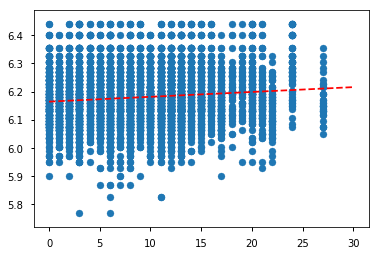

In [34]:
b0, m0 = pooled_sample['beta'].T.mean(1)
plt.scatter(df.year_teaching, np.log(df.math))
xvals = np.linspace(0,30)
plt.plot(xvals, m0*xvals+b0, 'r--')
plt.show()



In [36]:
#Comparing y_pred with y_test
MAE = np.sum(np.power(np.absolute(np.subtract(pooled_sample["y_pred_test"].mean(0), Y_test)),2))
print(MAE)

33.84244126764438


##  Separate model

In [37]:
separate_code = """
data{
    int<lower=0> N;
    int<lower=1, upper=79> school[N]; #school indicator
    vector[N] x;
    vector[N] y;
}
parameters {
    vector[79] alpha;
    real beta; #only 1 beta, not a vector
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] y_hat;  
    for (i in 1:N)
        y_hat[i] <- beta* x[i] + alpha[school[i]];
}
model {
    y ~ normal(y_hat, sigma);
}
generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| y_hat[i], sigma);
}
"""

In [38]:
separate_data = {'N': df.shape[0],
                 'school': star.schidkn,
                 'x': df.loc[:,'year_teaching'],
                 'x_test': df.loc[:,'year_teaching'],
                 'y': np.log(df.math) }

In [39]:
separate_fit = pystan.stan(model_code = separate_code, data = separate_data, iter = 1000, chains = 2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0658457e53e8959415aa44ade4e33d07 NOW.
/Users/haicuthe/anaconda2/envs/dev-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [40]:
print(separate_fit)
separate_sample = separate_fit.extract(permuted=True)


Inference for Stan model: anon_model_0658457e53e8959415aa44ade4e33d07.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[0]        6.19  3.4e-4   0.01   6.17   6.18   6.19    6.2   6.21   1000    1.0
alpha[1]         6.1  4.7e-4   0.01   6.07   6.09    6.1   6.11   6.12    666    1.0
alpha[2]        6.18  2.9e-4 9.1e-3   6.17   6.18   6.18   6.19    6.2   1000    1.0
alpha[3]        6.14  4.0e-4   0.01   6.12   6.13   6.14   6.15   6.16    879    1.0
alpha[4]        6.12  3.6e-4   0.01    6.1   6.11   6.12   6.13   6.14   1000    1.0
alpha[5]        6.14  3.8e-4   0.01   6.12   6.13   6.14   6.15   6.17   1000    1.0
alpha[6]        6.23  2.6e-4 8.2e-3   6.21   6.22   6.23   6.23   6.24   1000    1.0
alpha[7]        6.15  2.8e-4 8.9e-3   6.14   6.15   6.15   6.16   6.17   1000    1.0
alpha[8]        6.17  2.5e-4 8.0e-3   6.16   6.1

elpd_loo:  1949.512280489687
-1941.3987502511452


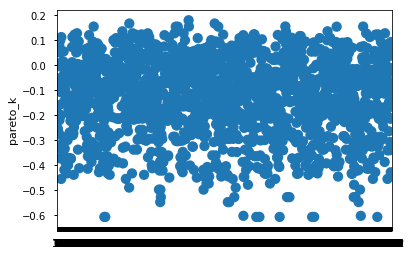

In [41]:
separate_sample = pooled_fit.extract(permuted=True)

loglik = (separate_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("elpd_loo: ",psisloo.elpd)
psisloo.plot()
lppd_pooled = 0 
for i in range (df.shape[1]):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print(peff_pooled)

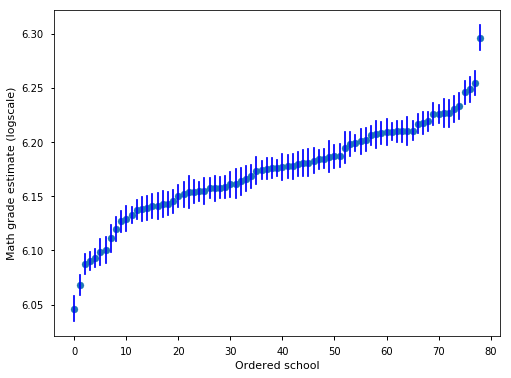

In [42]:
separate_sample = pd.Series(separate_fit['alpha'].mean(0), index=schools)
separate_sample_se = pd.Series(separate_fit['alpha'].std(0), index=schools)

order = separate_sample.sort_values().index
plt.figure(figsize = (8,6))
plt.scatter(range(len(separate_sample)), separate_sample[order])
for i, m, se in zip(range(len(separate_sample)), separate_sample[order], separate_sample_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.ylabel('Math grade estimate (logscale)');plt.xlabel('Ordered school');

# Varying intercept model

In [39]:
varying_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> school[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[J] a;
  real b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {

  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- a[school[i]] + x[i] * b;
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal (mu_a, sigma_a);

  b ~ normal (0, 1);

  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

In [40]:
varying_intercept_data = {'N': df.shape[0],
                          'J': 79,
                          'school': star.schidkn,
                          'x': df.loc[:,'year_teaching'],
                          'y': np.log(df.math)}

varying_intercept_fit = pystan.stan(model_code=varying_intercept, data=varying_intercept_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_94b3ae123b56a544ee9ed9ec87587d32 NOW.
/Users/haicuthe/anaconda2/envs/dev-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [63]:
star.schidkn.shape[0]

5748

In [41]:
a_sample = pd.DataFrame(varying_intercept_fit['a'])

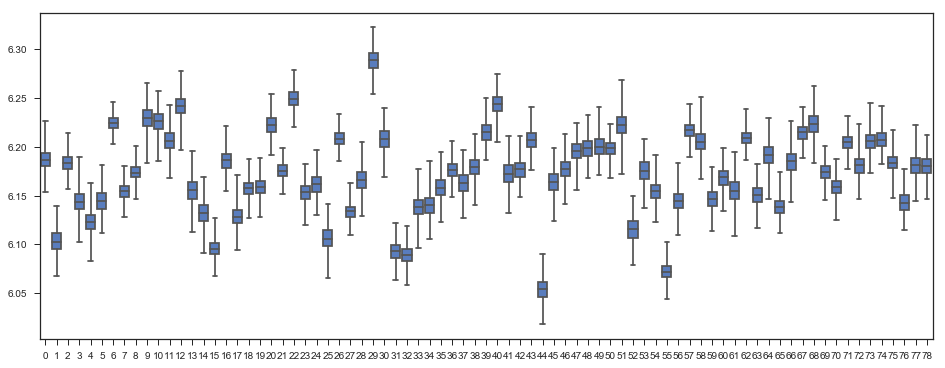

In [58]:
import seaborn as sns
sns.set(style="ticks")

plt.figure(figsize=(16, 6))
sns.boxplot(data=a_sample, whis=np.inf, color="b")

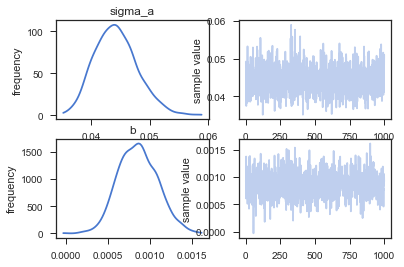

In [43]:
varying_intercept_fit.plot(pars=['sigma_a', 'b']);

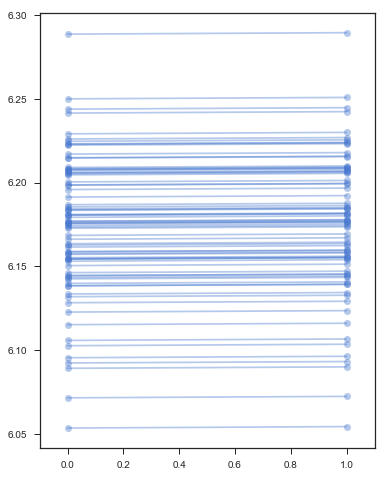

In [87]:
xvals = np.arange(2)
bp = varying_intercept_fit['a'].mean(axis=0)
mp = varying_intercept_fit['b'].mean()
plt.figure(figsize=(6,8))
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);

# Varying slop model

In [67]:
varying_slope = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> school[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  real a;
  vector[J] b;
  real mu_b;
  real<lower=0,upper=100> sigma_b;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {

  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- a + x[i] * b[school[i]];
}
model {
  sigma_b ~ uniform(0, 100);
  b ~ normal (mu_b, sigma_b);

  a ~ normal (0, 1);

  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

In [68]:
varying_slope_data = {'N': df.shape[0],
                          'J': 79,
                          'school': star.schidkn,
                          'x': df.loc[:,'year_teaching'],
                          'y': np.log(df.math)}

varying_slope_fit = pystan.stan(model_code=varying_slope, data=varying_slope_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1660a7a0034e3bf729ea4a0837e42db3 NOW.
/Users/haicuthe/anaconda2/envs/dev-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [69]:
b_sample = pd.DataFrame(varying_slope_fit['b'])

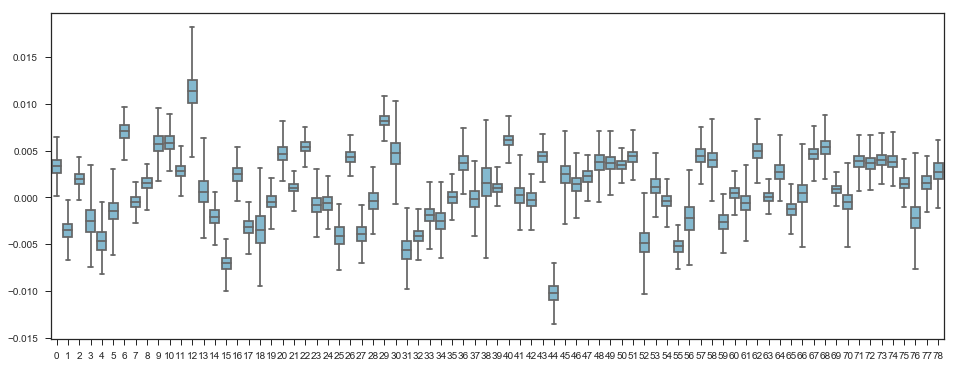

In [70]:
# Plot the orbital period with horizontal boxes
plt.figure(figsize=(16, 6))
sns.boxplot(data=b_sample, whis=np.inf, color="c")

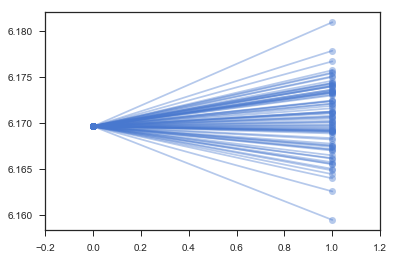

In [72]:
xvals = np.arange(2)
b = varying_slope_fit['a'].mean()
m = varying_slope_fit['b'].mean(axis=0)
plt.figure(figsize=(6,8))
for mi in m:
    plt.plot(xvals, mi*xvals + b, 'bo-', alpha=0.4)
plt.xlim(-0.2, 1.2);

# Varying intercept and slope model

In [76]:
varying_intercept_slope = """
data {
  int<lower=0> N;
  int<lower=0> J;
  vector[N] y;
  vector[N] x;
  int school[N];
}
parameters {
  real<lower=0> sigma;
  real<lower=0> sigma_a;
  real<lower=0> sigma_b;
  vector[J] a;
  vector[J] b;
  real mu_a;
  real mu_b;
}

model {
  mu_a ~ normal(0, 100);
  mu_b ~ normal(0, 100);

  a ~ normal(mu_a, sigma_a);
  b ~ normal(mu_b, sigma_b);
  y ~ normal(a[school] + b[school].*x, sigma);
}
"""

In [77]:
varying_intercept_slope_data = {'N': df.shape[0],
                          'J': 79,
                          'school': star.schidkn,
                          'x': df.loc[:,'year_teaching'],
                          'y': np.log(df.math)}

varying_intercept_slope_fit = pystan.stan(model_code=varying_intercept_slope, 
                                          data=varying_intercept_slope_data, 
                                          iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a84c8a70d43b509c9ad81e510737ff63 NOW.
/Users/haicuthe/anaconda2/envs/dev-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


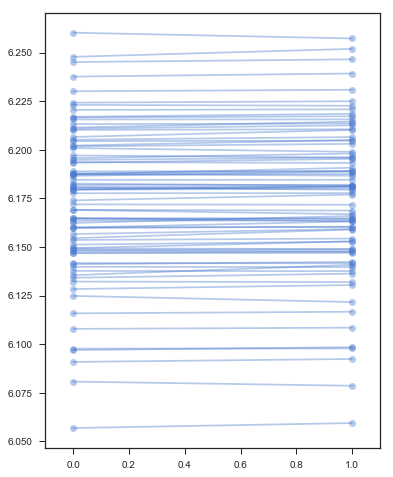

In [86]:
xvals = np.arange(2)
b = varying_intercept_slope_fit['a'].mean(axis=0)
m = varying_intercept_slope_fit['b'].mean(axis=0)
plt.figure(figsize=(6,8))
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);

In [80]:
bi

6.159970480233595